Goal: create maps of street networks, but only within a buffer around a geocoded place.

Next goal: functions to measure and visualize urban indicators.

Steps:
- write code to plot heatmap of point density [DONE]
- convert heatmap code to function [DONE]
- write code to clip heatmap to buffer ring
- write code to get osm amenity data based on category

Ideas for Urban Indicators:
- intersection density (hexbin/heatmap) [DONE]
- density of x-height buildings (hexbin/heatmap)
- density of x kind of amenity (hexbin/heatmap)
    - sustenance (restaurants, bars, etc.)
    - education (school, college, university, etc.)
    - healthcare (clinic, hospital, etc.)
    - public service (fire station, town hall, police, etc.)
- isochrone from geocoded point

In [1]:
import osmnx as ox
import geopandas as gpd
import contextily as cx
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

In [2]:
# PLACE_NAMES = [
#     # "Marikina, Metro Manila",
#     # "Quezon City, Metro Manila",
#     # "Manila, Metro Manila",
#     "Pasig, Metro Manila",
#     # "Taguig, Metro Manila"
# ]

In [3]:
# Set name for Nominatim query
query = "Marikina"
buffer_dist = 1_500

# Get buffer with aforementioned parameters using custom function
from urban_indicators_scripts import get_buffer_from_place

buffer = get_buffer_from_place(query, buffer_dist)

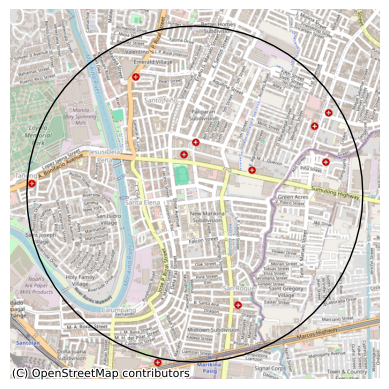

In [4]:
# Check if buffer location is correct
ax = buffer.to_crs("EPSG:3857").plot(
    facecolor="none"
)
cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

In [5]:
# Get road network within buffer
graph = ox.graph_from_polygon(
    buffer.geometry[0],
    network_type="all_private",
    retain_all=True
)

# Convert intersections and streets to geodataframe
intersections, streets = ox.graph_to_gdfs(graph)

In [6]:
# Reproject both GDFs to pseudo-mercator
streets = streets.to_crs("EPSG:3857")
intersections = intersections.to_crs("EPSG:3857")

In [7]:
# Parse `lanes` column in streets GDF using custom function
from urban_indicators_scripts import parse_street_lanes

streets = parse_street_lanes(streets)
streets.lanes.unique()

array([2, 1, 4, 6, 5, 3])

Examining the street intersections GDF

In [8]:
streets.head()

osmid  lanes                      name  \
u        v          key                                                
21322195 8489619532 0     357121634      2           Guerilla Street   
         8489619520 0    1178024567      2           Guerilla Street   
21322197 32284894   0       4357068      2    Eraño G. Manalo Street   
         33118939   0       4989944      2  F. Alfelor Senior Street   
         26546377   0     261332447      2           Aquilina Street   

                          highway maxspeed  oneway reversed   length  \
u        v          key                                                
21322195 8489619532 0    tertiary       40   False    False    6.322   
         8489619520 0    tertiary      NaN   False     True    5.717   
21322197 32284894   0    tertiary       40    True    False  264.153   
         33118939   0    tertiary      NaN   False     True   53.423   
         26546377   0    tertiary      NaN   False     True   86.098   

                                                                  geometry  \
u        v          key                                                      
21322195 8489619532 0    LINESTRING (13480558.757 1647485.444, 13480552...   
         8489619520 0    LINESTRING (13480558.757 1647485.444, 13480564...   
21322197 32284894   0    LINESTRING (13480761.292 1648028.435, 13480647...   
         33118939   0    LINESTRING (13480761.292 1648028.435, 13480711...   
         26546377   0    LINESTRING (13480761.292 1648028.435, 13480841...   

                        width bridge access  ref service tunnel  
u        v          key                                          
21322195 8489619532 0     NaN    NaN    NaN  NaN     NaN    NaN  
         8489619520 0     NaN    NaN    NaN  NaN     NaN    NaN  
21322197 32284894   0     NaN    NaN    NaN  NaN     NaN    NaN  
         33118939   0     NaN    NaN    NaN  NaN     NaN    NaN  
         26546377   0     NaN    NaN    NaN  NaN     NaN    NaN

In [9]:
intersections.head()

,y,x,street_count,highway,geometry
osmid,,,,,
21322195,14.637735,121.097920,3,NaN,POINT (13480558.757 1647485.444)
21322197,14.642454,121.099739,4,NaN,POINT (13480761.292 1648028.435)
21458363,14.621964,121.094744,4,NaN,POINT (13480205.184 1645671.008)
21458378,14.625139,121.102290,4,NaN,POINT (13481045.234 1646036.326)
21458401,14.623851,121.102234,4,NaN,POINT (13481039.056 1645888.111)


Plotting the street network and intersection heatmap

d:\WORK\ONLINE COURSES\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:383: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)


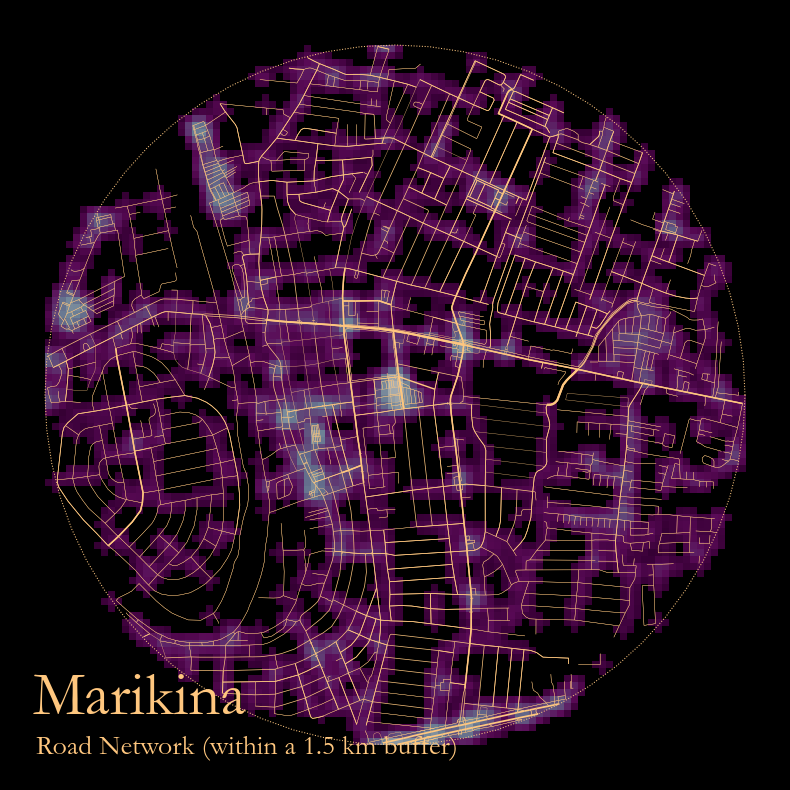

In [12]:
# Plot street network
from urban_indicators_scripts import plot_streets, plot_heatmap

fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    color_scheme="copper"
)

plot_heatmap(
    intersections,
    "street_count",
    ax=ax,
    alpha=0.7,
    color_scheme="BuPu_r",
    bounds=ring_bounds
)